# 向量存储与 embedding

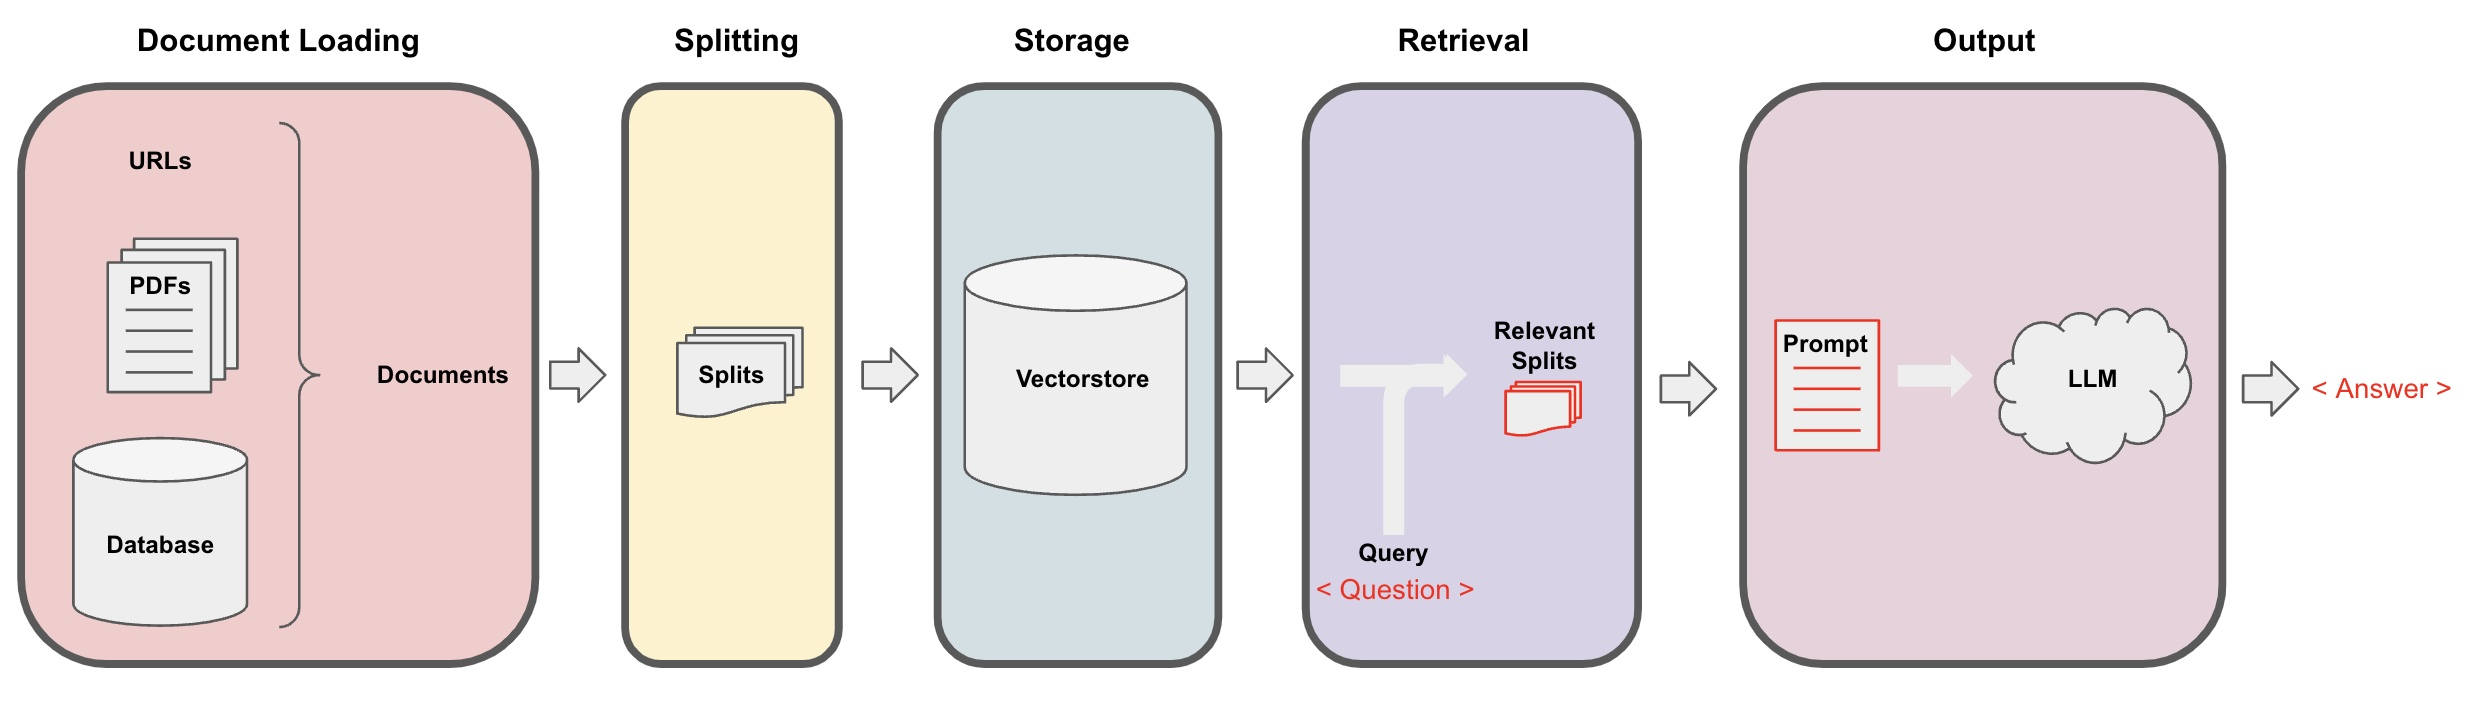

使用上一节使用的数据预处理的部分完成数据加载

In [ ]:
import os
import openai
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

#API_KEY = "YOUR_TONG_API_KEY"
#os.environ["AZURE_OPENAI_API_KEY"] = API_KEY

REGION = "eastus"
API_BASE = "https://api.tonggpt.mybigai.ac.cn/proxy"
ENDPOINT = f"{API_BASE}/{REGION}"

openai.azure_endpoint = ENDPOINT
os.environ["AZURE_OPENAI_ENDPOINT"] = ENDPOINT
os.environ["OPENAI_API_VERSION"] = "2024-02-01"

In [ ]:
from langchain.document_loaders import PyPDFLoader
import glob

# Load PDF

# loaders = [
#     PyPDFLoader(doc_path) for doc_path in glob.glob("docs/cs229_lectures/*.pdf")
# ]

loaders = [
    # Duplicate documents on purpose - messy data
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture01.pdf"),
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture02.pdf"),
    PyPDFLoader("docs/cs229_lectures/MachineLearning-Lecture03.pdf")
]

docs = []
for loader in loaders:
    docs.extend(loader.load())

In [ ]:
docs[0]

In [ ]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=150,
    separators=[
        "\n\n",
        "\n",
        " ",
        ".",
        ",",
        "\u200b",  # Zero-width space
        "\uff0c",  # Fullwidth comma
        "\u3001",  # Ideographic comma
        "\uff0e",  # Fullwidth full stop
        "\u3002",  # Ideographic full stop
        "",
    ],
)

In [ ]:
splits = text_splitter.split_documents(docs)

In [ ]:
print("splits: ", len(splits))
print("docs: ", len(docs))

## Embeddings

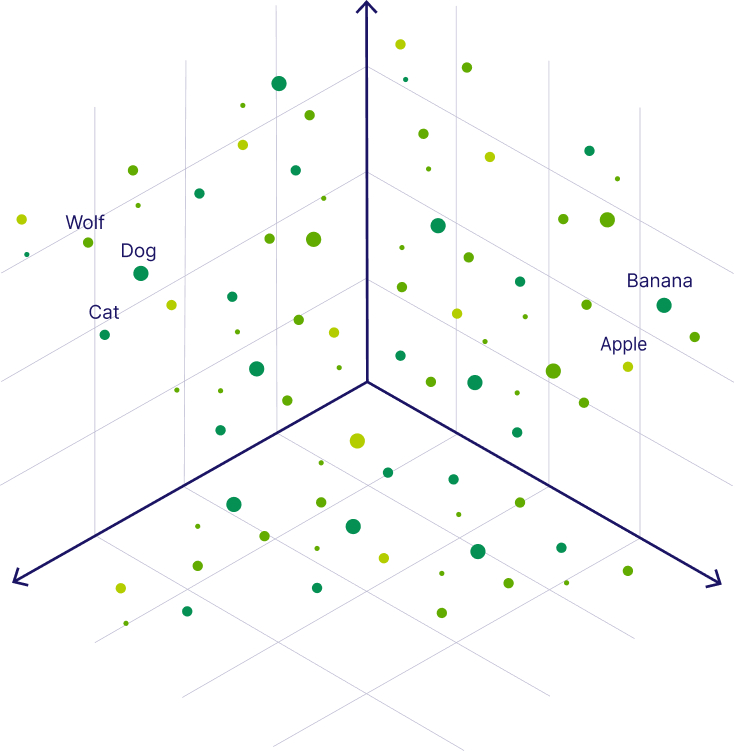

embedding将切分好的文本块映射至向量空间中的点。  
语义接近的词句对应的点在向量空间中通常相互接近，语义差别较大的则距离较远。  

我们来对切分后的文本块进行embedding

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.embeddings.azure_openai import AzureOpenAIEmbeddings

#embedding = OpenAIEmbeddings(openai_api_key=API_KEY)
openai_embedding = AzureOpenAIEmbeddings(
    azure_endpoint=ENDPOINT,
    model="text-embedding-3-small",
    chunk_size=8)

In [ ]:
sentence1 = "i like banana"
sentence2 = "i like fruit"
sentence3 = "RAG is cool"

In [ ]:
embedding1 = openai_embedding.embed_query(sentence1)
embedding2 = openai_embedding.embed_query(sentence2)
embedding3 = openai_embedding.embed_query(sentence3)

In [ ]:
print(embedding1)

In [ ]:
import numpy as np

In [ ]:
np.dot(embedding1, embedding2)

In [ ]:
np.dot(embedding1, embedding3)

In [ ]:
np.dot(embedding2, embedding3)

## 向量数据库

In [ ]:
! pip install chromadb

很多向量库包含embedding 和相应工具类，使用LangChain 可以很方便的访问和使用。

In [ ]:
from chromadb.utils import embedding_functions
from langchain_core.embeddings import Embeddings
from typing import List

default_ef = embedding_functions.DefaultEmbeddingFunction()


class DefaultChromaEmbedding(Embeddings):
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        return default_ef(texts)

    def embed_query(self, text: str) -> List[float]:
        return default_ef([text])[0]

chroma_embedding = DefaultChromaEmbedding()

In [ ]:
embedding1 = chroma_embedding.embed_query(sentence1)
embedding2 = chroma_embedding.embed_query(sentence2)
embedding3 = chroma_embedding.embed_query(sentence3)
print(np.dot(embedding1, embedding2))

In [ ]:
from langchain.vectorstores import Chroma

In [ ]:
persist_directory = 'docs/data/chroma/'

In [ ]:
# remove old database files if any
import shutil
import os
if os.path.exists(persist_directory):
    shutil.rmtree(persist_directory)

In [ ]:
vectordb = Chroma.from_documents(
    documents=splits,
    embedding=chroma_embedding,
    persist_directory=persist_directory
)

In [ ]:
print(vectordb._collection.count())

### 相似度搜索 (Similarity Search)

In [ ]:
question = "is there an email i can ask for help"

In [ ]:
docs = vectordb.similarity_search(question,k=3)

In [ ]:
for doc in docs:
    print(doc.metadata)
    print(doc.page_content)
    print("===============")

对向量数据进行持久化，后续章节我们还会用到

In [ ]:
vectordb.persist()